In [1]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as sk_ms
import sklearn.metrics as sk_mt
import sklearn.preprocessing as sk_p
import sklearn.utils as sk_ut
import numpy as np
import keras.models as k_mod
import keras.layers as k_lay
import keras.optimizers as k_opt
import keras.utils as k_ut

import utils

Using TensorFlow backend.


In [2]:
with open('cnn_input_ds.pkl', 'rb') as f:
    tweets_ds = pickle.load(f)

In [3]:
tweets_ds

{'tweets': [array([[ 0.57823   ,  0.20081819, -0.20082252, -0.20420552, -0.09189861,
           0.06605601,  0.03429733,  1.84374138, -0.18774231, -0.04618484,
          -0.55698273, -1.02727075, -4.01081061,  0.0184011 , -0.89515656,
          -0.40863596, -0.9445353 , -0.03097671, -0.93359545,  0.30778441,
          -0.15797814, -0.36823548,  0.46933611,  0.25143739,  0.3130394 ],
         [ 0.71118901,  0.148014  , -0.11327621, -0.2448282 , -0.09016343,
           0.03572511, -0.07696076,  1.82289681,  0.02479892, -0.07067709,
          -0.63424703, -1.13565147, -3.8367022 , -0.06172446, -0.93646049,
          -0.49870953, -1.05115802, -0.03579231, -1.00278495,  0.3187458 ,
          -0.2446442 , -0.30945079,  0.42720715,  0.37712716,  0.31227284],
         [ 0.64802938,  0.21894636, -0.18367263, -0.29344054, -0.0765711 ,
           0.06084711, -0.06501834,  1.86357246, -0.02182978, -0.02072832,
          -0.594171  , -1.04352513, -3.88588846,  0.00783315, -0.93586151,
          -0.

In [4]:
users_ds = pd.read_csv('../../dataset/final_dataset/twitter_patterns_with_graph.csv')

In [5]:
user_2_tweets = {}
user_2_stats = {}
user_2_group = {}

for entry in users_ds.values:
    user_2_stats[entry[1]] = entry[2:]
    user_2_group[entry[1]] = entry[0]
    
for entry in zip(tweets_ds['username'], tweets_ds['tweets']):
    user_2_tweets[entry[0]] = entry[1]

In [6]:
lb = sk_p.LabelBinarizer()
lb.fit(list(set(user_2_group.values())))

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [7]:
cnn_x = []
add_x = []
groups = []

for u in user_2_group.keys():
    cnn_x.append(user_2_tweets[u])
    add_x.append(user_2_stats[u])
    groups.append(user_2_group[u])

In [8]:
cnn_x = np.array(cnn_x).astype('float64')
add_x = np.array(add_x).astype('float64')

In [9]:
cnn_input_shape = cnn_x[0].shape
add_input_shape = add_x[0].shape
groups_num = len(set(user_2_group.values()))
test_split = 0.1

In [10]:
cnn_x, add_x, groups = sk_ut.shuffle(cnn_x, add_x, groups)
groups = np.array(groups)
groups = lb.transform(groups)

In [11]:
cnn_x_train, cnn_x_test, add_x_train, add_x_test, y_train, y_test = sk_ms.train_test_split(
    cnn_x, add_x, groups, test_size=test_split, shuffle=True)

In [12]:
cnn_input = k_lay.Input(shape=cnn_input_shape, name='cnn_input')
net_x = k_lay.Conv1D(32, kernel_size=3, activation='sigmoid')(cnn_input)
net_x = k_lay.Conv1D(32, kernel_size=3, activation='sigmoid')(net_x)
net_x = k_lay.Flatten()(net_x)

additional_input = k_lay.Input(shape=add_input_shape, name='additional_input')
net_common = k_lay.merge.Concatenate()([net_x, additional_input])
net_common = k_lay.Dense(64, activation='sigmoid')(net_common)
net_common - k_lay.Dropout(0.5)(net_common)
final_output = k_lay.Dense(groups_num, activation='softmax', name='final_output')(net_common)

model = k_mod.Model(inputs=[cnn_input, additional_input], outputs=[final_output])
model.compile(optimizer=k_opt.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          (None, 5, 25)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3, 32)        2432        cnn_input[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1, 32)        3104        conv1d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 32)           0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
additional

In [13]:
history = model.fit([cnn_x_train, add_x_train], y_train, epochs=500, batch_size=128, validation_split=test_split)

Train on 332 samples, validate on 37 samples
Epoch 1/500
332/332 [==============================] - 0s 1ms/step - loss: 1.7221 - acc: 0.2169 - val_loss: 1.6707 - val_acc: 0.1892
Epoch 2/500
332/332 [==============================] - 0s 34us/step - loss: 1.6160 - acc: 0.2229 - val_loss: 1.5780 - val_acc: 0.1892
Epoch 3/500
332/332 [==============================] - 0s 31us/step - loss: 1.5243 - acc: 0.2289 - val_loss: 1.4988 - val_acc: 0.2432
Epoch 4/500
332/332 [==============================] - 0s 34us/step - loss: 1.4454 - acc: 0.2620 - val_loss: 1.4231 - val_acc: 0.3243
Epoch 5/500
332/332 [==============================] - 0s 32us/step - loss: 1.3657 - acc: 0.2982 - val_loss: 1.3673 - val_acc: 0.3243
Epoch 6/500
332/332 [==============================] - 0s 37us/step - loss: 1.3001 - acc: 0.3494 - val_loss: 1.3151 - val_acc: 0.4595
Epoch 7/500
332/332 [==============================] - 0s 39us/step - loss: 1.2521 - acc: 0.4518 - val_loss: 1.2784 - val_acc: 0.5676
Epoch 8/500
332/33

332/332 [==============================] - 0s 45us/step - loss: 0.9278 - acc: 0.5994 - val_loss: 1.1155 - val_acc: 0.4595
Epoch 62/500
332/332 [==============================] - 0s 35us/step - loss: 0.9256 - acc: 0.5994 - val_loss: 1.1114 - val_acc: 0.4595
Epoch 63/500
332/332 [==============================] - 0s 39us/step - loss: 0.9249 - acc: 0.6054 - val_loss: 1.1094 - val_acc: 0.4595
Epoch 64/500
332/332 [==============================] - 0s 35us/step - loss: 0.9232 - acc: 0.6024 - val_loss: 1.1122 - val_acc: 0.4595
Epoch 65/500
332/332 [==============================] - 0s 36us/step - loss: 0.9210 - acc: 0.5904 - val_loss: 1.1144 - val_acc: 0.4324
Epoch 66/500
332/332 [==============================] - 0s 38us/step - loss: 0.9191 - acc: 0.5964 - val_loss: 1.1143 - val_acc: 0.4595
Epoch 67/500
332/332 [==============================] - 0s 37us/step - loss: 0.9172 - acc: 0.5964 - val_loss: 1.1144 - val_acc: 0.4595
Epoch 68/500
332/332 [==============================] - 0s 37us/step

332/332 [==============================] - 0s 46us/step - loss: 0.8407 - acc: 0.6355 - val_loss: 1.0651 - val_acc: 0.5135
Epoch 122/500
332/332 [==============================] - 0s 37us/step - loss: 0.8393 - acc: 0.6325 - val_loss: 1.0640 - val_acc: 0.5135
Epoch 123/500
332/332 [==============================] - 0s 43us/step - loss: 0.8383 - acc: 0.6325 - val_loss: 1.0646 - val_acc: 0.4865
Epoch 124/500
332/332 [==============================] - 0s 45us/step - loss: 0.8371 - acc: 0.6386 - val_loss: 1.0634 - val_acc: 0.4865
Epoch 125/500
332/332 [==============================] - 0s 72us/step - loss: 0.8355 - acc: 0.6446 - val_loss: 1.0571 - val_acc: 0.4865
Epoch 126/500
332/332 [==============================] - 0s 48us/step - loss: 0.8347 - acc: 0.6355 - val_loss: 1.0565 - val_acc: 0.5135
Epoch 127/500
332/332 [==============================] - 0s 39us/step - loss: 0.8333 - acc: 0.6325 - val_loss: 1.0559 - val_acc: 0.5135
Epoch 128/500
332/332 [==============================] - 0s 42

332/332 [==============================] - 0s 35us/step - loss: 0.7700 - acc: 0.6627 - val_loss: 1.0544 - val_acc: 0.4595
Epoch 182/500
332/332 [==============================] - 0s 36us/step - loss: 0.7695 - acc: 0.6717 - val_loss: 1.0560 - val_acc: 0.4595
Epoch 183/500
332/332 [==============================] - 0s 36us/step - loss: 0.7673 - acc: 0.6777 - val_loss: 1.0592 - val_acc: 0.4595
Epoch 184/500
332/332 [==============================] - 0s 44us/step - loss: 0.7661 - acc: 0.6717 - val_loss: 1.0572 - val_acc: 0.4595
Epoch 185/500
332/332 [==============================] - 0s 43us/step - loss: 0.7645 - acc: 0.6777 - val_loss: 1.0538 - val_acc: 0.4595
Epoch 186/500
332/332 [==============================] - 0s 36us/step - loss: 0.7635 - acc: 0.6717 - val_loss: 1.0557 - val_acc: 0.4595
Epoch 187/500
332/332 [==============================] - 0s 36us/step - loss: 0.7620 - acc: 0.6687 - val_loss: 1.0559 - val_acc: 0.4324
Epoch 188/500
332/332 [==============================] - 0s 37

332/332 [==============================] - 0s 34us/step - loss: 0.6912 - acc: 0.7018 - val_loss: 1.0161 - val_acc: 0.4595
Epoch 242/500
332/332 [==============================] - 0s 36us/step - loss: 0.6908 - acc: 0.6988 - val_loss: 1.0200 - val_acc: 0.4595
Epoch 243/500
332/332 [==============================] - 0s 40us/step - loss: 0.6908 - acc: 0.7048 - val_loss: 1.0255 - val_acc: 0.4595
Epoch 244/500
332/332 [==============================] - 0s 36us/step - loss: 0.6952 - acc: 0.7048 - val_loss: 1.0286 - val_acc: 0.4324
Epoch 245/500
332/332 [==============================] - 0s 60us/step - loss: 0.6979 - acc: 0.7048 - val_loss: 1.0206 - val_acc: 0.4595
Epoch 246/500
332/332 [==============================] - 0s 60us/step - loss: 0.6959 - acc: 0.6988 - val_loss: 1.0151 - val_acc: 0.4595
Epoch 247/500
332/332 [==============================] - 0s 50us/step - loss: 0.6906 - acc: 0.7108 - val_loss: 1.0152 - val_acc: 0.4324
Epoch 248/500
332/332 [==============================] - 0s 52

332/332 [==============================] - 0s 42us/step - loss: 0.6478 - acc: 0.7289 - val_loss: 0.9833 - val_acc: 0.4595
Epoch 302/500
332/332 [==============================] - 0s 39us/step - loss: 0.6452 - acc: 0.7349 - val_loss: 0.9838 - val_acc: 0.4595
Epoch 303/500
332/332 [==============================] - 0s 42us/step - loss: 0.6489 - acc: 0.7380 - val_loss: 0.9927 - val_acc: 0.4595
Epoch 304/500
332/332 [==============================] - 0s 41us/step - loss: 0.6574 - acc: 0.7319 - val_loss: 0.9926 - val_acc: 0.4595
Epoch 305/500
332/332 [==============================] - 0s 43us/step - loss: 0.6589 - acc: 0.7319 - val_loss: 0.9747 - val_acc: 0.4865
Epoch 306/500
332/332 [==============================] - 0s 37us/step - loss: 0.6590 - acc: 0.7319 - val_loss: 0.9768 - val_acc: 0.4865
Epoch 307/500
332/332 [==============================] - 0s 31us/step - loss: 0.6538 - acc: 0.7289 - val_loss: 0.9744 - val_acc: 0.4865
Epoch 308/500
332/332 [==============================] - 0s 37

332/332 [==============================] - 0s 78us/step - loss: 0.6119 - acc: 0.7620 - val_loss: 0.9326 - val_acc: 0.5135
Epoch 362/500
332/332 [==============================] - 0s 50us/step - loss: 0.6187 - acc: 0.7500 - val_loss: 0.9344 - val_acc: 0.5405
Epoch 363/500
332/332 [==============================] - 0s 64us/step - loss: 0.6136 - acc: 0.7620 - val_loss: 0.9571 - val_acc: 0.5405
Epoch 364/500
332/332 [==============================] - 0s 65us/step - loss: 0.6253 - acc: 0.7681 - val_loss: 0.9637 - val_acc: 0.5405
Epoch 365/500
332/332 [==============================] - 0s 58us/step - loss: 0.6329 - acc: 0.7590 - val_loss: 0.9684 - val_acc: 0.5405
Epoch 366/500
332/332 [==============================] - 0s 46us/step - loss: 0.6290 - acc: 0.7620 - val_loss: 0.9659 - val_acc: 0.5676
Epoch 367/500
332/332 [==============================] - 0s 43us/step - loss: 0.6235 - acc: 0.7470 - val_loss: 0.9683 - val_acc: 0.5676
Epoch 368/500
332/332 [==============================] - 0s 37

332/332 [==============================] - 0s 48us/step - loss: 0.5802 - acc: 0.7801 - val_loss: 0.9300 - val_acc: 0.5676
Epoch 422/500
332/332 [==============================] - 0s 45us/step - loss: 0.5820 - acc: 0.7801 - val_loss: 0.9256 - val_acc: 0.5676
Epoch 423/500
332/332 [==============================] - 0s 44us/step - loss: 0.5775 - acc: 0.7892 - val_loss: 0.9210 - val_acc: 0.5135
Epoch 424/500
332/332 [==============================] - 0s 47us/step - loss: 0.5773 - acc: 0.7922 - val_loss: 0.9236 - val_acc: 0.5135
Epoch 425/500
332/332 [==============================] - 0s 46us/step - loss: 0.5756 - acc: 0.7982 - val_loss: 0.9271 - val_acc: 0.5135
Epoch 426/500
332/332 [==============================] - 0s 54us/step - loss: 0.5763 - acc: 0.7831 - val_loss: 0.9282 - val_acc: 0.5135
Epoch 427/500
332/332 [==============================] - 0s 44us/step - loss: 0.5744 - acc: 0.7892 - val_loss: 0.9212 - val_acc: 0.5135
Epoch 428/500
332/332 [==============================] - 0s 42

332/332 [==============================] - 0s 43us/step - loss: 0.5427 - acc: 0.8102 - val_loss: 0.9425 - val_acc: 0.5405
Epoch 482/500
332/332 [==============================] - 0s 49us/step - loss: 0.5432 - acc: 0.8072 - val_loss: 0.9277 - val_acc: 0.4865
Epoch 483/500
332/332 [==============================] - 0s 48us/step - loss: 0.5407 - acc: 0.8193 - val_loss: 0.9226 - val_acc: 0.4865
Epoch 484/500
332/332 [==============================] - 0s 40us/step - loss: 0.5391 - acc: 0.8133 - val_loss: 0.9293 - val_acc: 0.4865
Epoch 485/500
332/332 [==============================] - 0s 37us/step - loss: 0.5433 - acc: 0.8133 - val_loss: 0.9356 - val_acc: 0.4865
Epoch 486/500
332/332 [==============================] - 0s 45us/step - loss: 0.5438 - acc: 0.8133 - val_loss: 0.9447 - val_acc: 0.4865
Epoch 487/500
332/332 [==============================] - 0s 53us/step - loss: 0.5550 - acc: 0.8012 - val_loss: 0.9488 - val_acc: 0.4865
Epoch 488/500
332/332 [==============================] - 0s 42

In [14]:
pred = model.predict([cnn_x_test, add_x_test])
pred_wrap = [np.argmax(p) for p in pred]
y_pred = lb.inverse_transform(k_ut.to_categorical(pred_wrap))
y_test_wrap = lb.inverse_transform(y_test)

In [15]:
print(sk_mt.classification_report(y_test_wrap, y_pred))

              precision    recall  f1-score   support

      actors       0.25      0.75      0.38         4
    athletes       0.56      0.38      0.45        13
   musicians       0.64      0.54      0.58        13
 politicians       1.00      0.83      0.91        12

   micro avg       0.60      0.60      0.60        42
   macro avg       0.61      0.63      0.58        42
weighted avg       0.68      0.60      0.62        42



In [16]:
utils.print_scores(*utils.score(y_test_wrap, y_pred))

acc 0.5952380952380952
f1 0.5804924242424243
prec 0.610479797979798
rec 0.6266025641025641


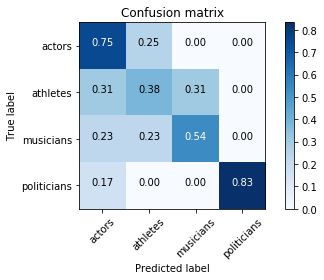

In [17]:
utils.plot_confusion_matrix(y_test_wrap, y_pred, sorted(set(y_test_wrap)))

In [18]:
dump_data = {
    'train_cnn_x': cnn_x_train,
    'test_cnn_x': cnn_x_test,
    'train_add_x': add_x_train,
    'test_add_x': add_x_test,
    'train_groups': y_train,
    'test_groups': y_test
}

with open('cnn_add_state_dataset.pkl', 'wb') as f:
    pickle.dump(dump_data, f)
    
model.save('cnn_add_state_model.h5')

In [19]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

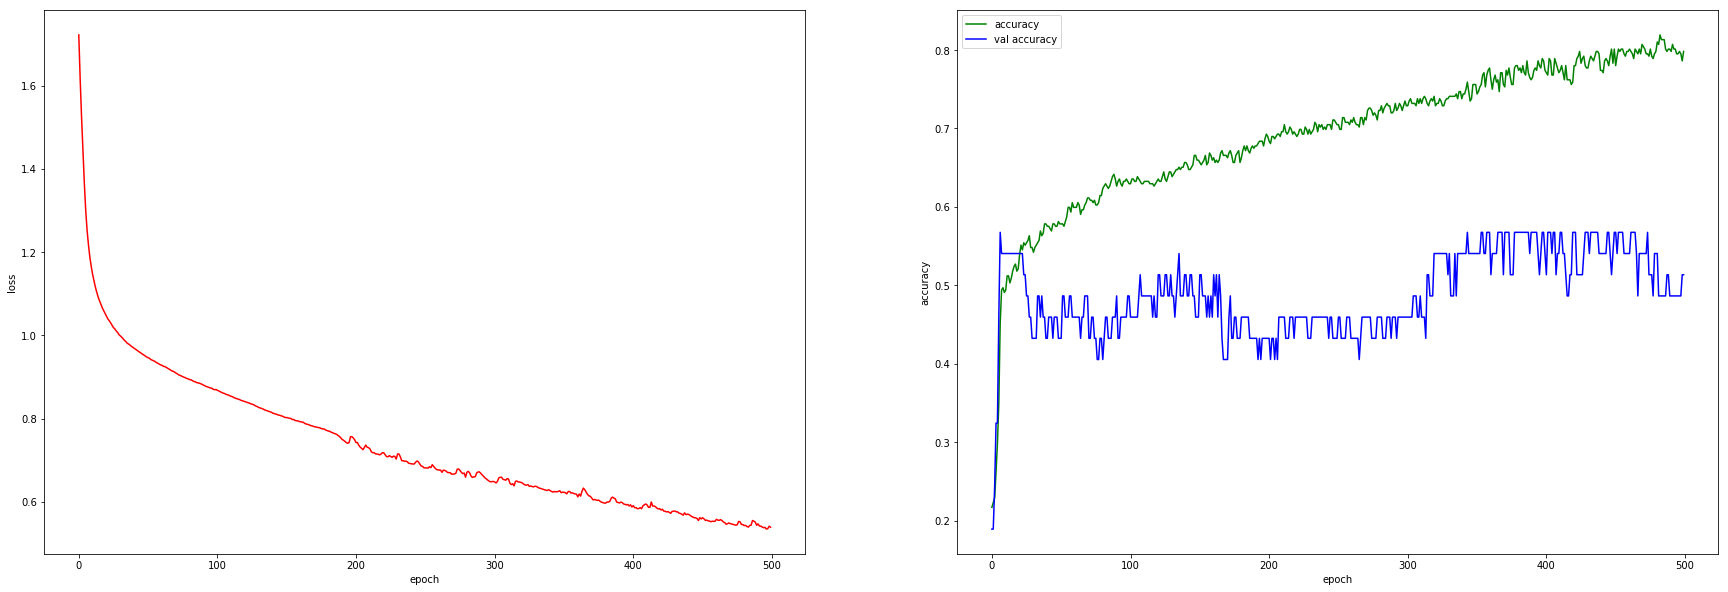

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))

l1, = ax1.plot(list(range(500)), history.history['loss'], color='r')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

l2, = ax2.plot(list(range(500)), history.history['acc'], color='g')
l3, = ax2.plot(list(range(500)), history.history['val_acc'], color='b')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

ax2.legend([l2, l3], ['accuracy', 'val accuracy'])

f.savefig('plots.png', dpi=600)